In [114]:
from google.cloud import bigquery
from google.cloud import storage
import pandas as pd
import numpy as np

from scipy import stats
from dython.nominal import associations

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot  as plt
import math


In [115]:
isLastUpdate=True
label='severity_id'
labelName='severity_name'

to_where='local'
is_splited=False

threshold_x_sd = 3

removeCols=['id','updated_at','imported_at']

dateCols=['open_datetime','close_datetime','response_datetime','resolved_datetime']

numbericCols=['count_detail','open_to_close_hour','open_to_response_hour','response_to_resolved_hour']
#numbericCols=['count_detail','open_to_close_hour']

cateCols=['sla','product_type','brand','service_type','incident_type']

In [116]:
def load_data_bq(sql:str):
 client_bq = bigquery.Client()
 query_result=client_bq.query(sql)
 df_all=query_result.to_dataframe()
 return df_all

In [117]:
sql_all="""

SELECT  id,
severity_id,severity_name,
count_detail,sla,
product_type,brand,service_type,incident_type,
open_datetime,  close_datetime, response_datetime,resolved_datetime, 
updated_at,imported_at
FROM `pongthorn.SMartDW.incident` WHERE open_datetime > '2000-01-01'

order by imported_at

"""

if isLastUpdate:
    print("Load data from Bigquery")
    df_all=load_data_bq(sql_all)
    if len(df_all)>0:
     df_all.to_csv('data/Incident.csv',index=False)
    else:
     print("No records from bigquery")   
else:
    print("Load data from Load CSV")
    df_all=pd.read_csv('data/Incident.csv',parse_dates=dateCols)
    
df_all=df_all.drop_duplicates(subset=['id'],keep='first')

df_all.info()


Load data from Bigquery
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2273 entries, 0 to 2276
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 2273 non-null   int64         
 1   severity_id        2273 non-null   int64         
 2   severity_name      2273 non-null   object        
 3   count_detail       2273 non-null   int64         
 4   sla                2273 non-null   object        
 5   product_type       2273 non-null   object        
 6   brand              2273 non-null   object        
 7   service_type       2273 non-null   object        
 8   incident_type      2273 non-null   object        
 9   open_datetime      2273 non-null   datetime64[ns]
 10  close_datetime     2273 non-null   datetime64[ns]
 11  response_datetime  2273 non-null   datetime64[ns]
 12  resolved_datetime  2273 non-null   datetime64[ns]
 13  updated_at         2273 non-null   date

# Manage Numberic Cols

In [118]:
start_end_list=[ ['open_datetime','close_datetime'],['open_datetime','response_datetime'],['response_datetime','resolved_datetime']]
listDiffDateDeltaCols=[]
listDiffHourCols=[]
for item  in  start_end_list:
   diff_str=f"{item[0]}_to_{item[1]}" 
   diff_str=diff_str.replace('_datetime','')  
   listDiffDateDeltaCols.append(diff_str)
   df_all[diff_str]=df_all[item[1]]-df_all[item[0]]
    
   diff_hour=f'{diff_str}_hour'
   listDiffHourCols.append(diff_hour)
   df_all[diff_hour] = df_all[diff_str].apply(lambda x:  x.total_seconds() / (60*60) if x is not np.nan else np.nan  )
xScoreDiffHourCols=[]
for col in listDiffHourCols:
  z_col=f"zscore_{col}"   
  df_all[z_col] = np.abs(stats.zscore(df_all[col]))   
  xScoreDiffHourCols.append(z_col)  
#remove oulier

for col in  xScoreDiffHourCols:
  df_all=df_all.query(f"{col}<@threshold_x_sd")

In [119]:
print(df_all.shape)
df_all.tail()

(2221, 24)


,id,severity_id,severity_name,count_detail,sla,product_type,brand,service_type,incident_type,open_datetime,...,imported_at,open_to_close,open_to_close_hour,open_to_response,open_to_response_hour,response_to_resolved,response_to_resolved_hour,zscore_open_to_close_hour,zscore_open_to_response_hour,zscore_response_to_resolved_hour
2272,2421,2,Major,1,24x7 4Hrs Resolution Time,Software,Veeam,Incident,Software,2023-03-10 16:23:00,...,2023-03-13 21:00:05.778139,3 days 06:22:00,78.366667,0 days 00:10:00,0.166667,0 days 00:12:00,0.200000,0.135137,0.098378,0.204555
2273,2391,2,Major,4,24x7 6Hrs Response Time,Server,HPE,Incident,General Incident,2023-03-03 16:38:00,...,2023-03-13 21:00:05.778139,9 days 23:47:00,239.783333,0 days 00:00:00,0.000000,9 days 23:47:00,239.783333,0.092440,0.102468,0.166832
2274,2428,3,Minor,1,24x7 6Hrs Resolution Time,Software,SAPB1,Incident,Software,2023-03-07 14:58:00,...,2023-03-13 21:00:05.778139,3 days 02:02:00,74.033333,0 days 00:02:00,0.033333,3 days 00:05:00,72.083333,0.141247,0.101650,0.093126
2275,2410,3,Minor,2,24x7 4Hrs Response Time,Software,Trend Micro,Request,Software,2023-03-08 11:34:00,...,2023-03-13 21:00:05.778139,0 days 02:00:00,2.000000,0 days 00:05:00,0.083333,0 days 01:55:00,1.916667,0.242804,0.100423,0.201894
2276,2402,2,Major,2,24x7 4Hrs Response Time,Software,VMWare,Incident,Software,2023-03-06 22:30:00,...,2023-03-13 21:00:05.778139,0 days 01:00:00,1.000000,0 days 00:15:00,0.250000,0 days 00:45:00,0.750000,0.244214,0.096333,0.203703


# Find any rows  contain 0

In [120]:

# if>5%  remove column, else judge to remove 0 value 
# remove coundetail because mostly, there are few value 1,2 items
allRows=df_all.shape[0]
for col in numbericCols:
    zeroRows=len(df_all.query(f"{col}==0"))
    pctZeroHour=round(zeroRows/allRows*100,1)
    print(f"No. 0-hour row on {col} = {zeroRows}({pctZeroHour} %)")

No. 0-hour row on count_detail = 116(5.2 %)
No. 0-hour row on open_to_close_hour = 1(0.0 %)
No. 0-hour row on open_to_response_hour = 435(19.6 %)
No. 0-hour row on response_to_resolved_hour = 92(4.1 %)


# Bining Range

In [121]:
def explore_ranges_numberic_val(col,rangeList):
    print(col)
    rangeList.sort()
    return pd.cut(df_all[col],rangeList, right=True).value_counts()
range1= [0,24, 168, 360, 720,math.floor(df_all['open_to_close_hour'].max())]
print(explore_ranges_numberic_val('open_to_close_hour',range1))
print("=======================================================")

range2= [0,24, 168, 360, 720,math.floor(df_all['response_to_resolved_hour'].max())]
print(explore_ranges_numberic_val('response_to_resolved_hour',range2))
print("=======================================================")

range3= [0,4, 8, 12, 24,math.floor(df_all['open_to_response_hour'].max())]
print(explore_ranges_numberic_val('open_to_response_hour',range3))
print("=======================================================")

range4= [0,2, 4,math.floor(df_all['count_detail'].max())]
print(explore_ranges_numberic_val('count_detail',range4))
print("=======================================================")

open_to_close_hour
(0, 24]        1512
(24, 168]       444
(168, 360]      116
(720, 2022]      86
(360, 720]       61
Name: open_to_close_hour, dtype: int64
response_to_resolved_hour
(0, 24]        1577
(24, 168]       358
(168, 360]       92
(720, 1988]      57
(360, 720]       44
Name: response_to_resolved_hour, dtype: int64
open_to_response_hour
(0, 4]      1654
(12, 24]      44
(24, 96]      33
(4, 8]        32
(8, 12]       22
Name: open_to_response_hour, dtype: int64
count_detail
(0, 2]     1677
(2, 4]      258
(4, 35]     170
Name: count_detail, dtype: int64


In [122]:
print("remove some cate featurs that have imcompelte data")
numColsRemove=['open_to_response_hour','count_detail'] 
numbericCols=[x for x in numbericCols if x not in numColsRemove]   
numbericCols

remove some cate featurs that have imcompelte data


['open_to_close_hour', 'response_to_resolved_hour']

In [123]:
# remove response_to_resolved_hour ,it doesn't make any sense
df_all=df_all.query('response_to_resolved_hour!=0')

In [124]:
removeCols=removeCols+dateCols+xScoreDiffHourCols+listDiffDateDeltaCols+numColsRemove
df_all=df_all.drop(columns=removeCols)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2129 entries, 0 to 2276
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   severity_id                2129 non-null   int64  
 1   severity_name              2129 non-null   object 
 2   sla                        2129 non-null   object 
 3   product_type               2129 non-null   object 
 4   brand                      2129 non-null   object 
 5   service_type               2129 non-null   object 
 6   incident_type              2129 non-null   object 
 7   open_to_close_hour         2129 non-null   float64
 8   response_to_resolved_hour  2129 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 166.3+ KB


In [125]:
df_all[numbericCols].describe()

,open_to_close_hour,response_to_resolved_hour
count,2129.000000,2129.000000
mean,96.175380,70.619853
std,263.309816,217.724293
min,0.166667,0.016667
25%,4.200000,3.000000
50%,8.716667,6.983333
75%,41.750000,25.300000
max,2022.583333,1988.400000


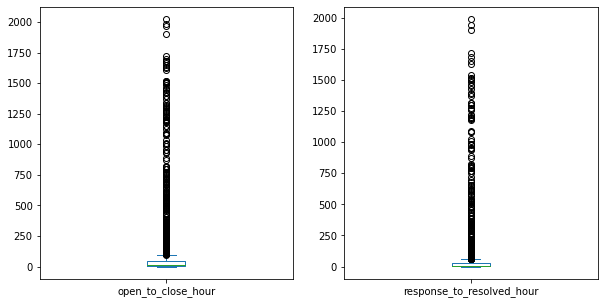

In [126]:
df_all[numbericCols].plot(kind='box',subplots=True,layout=(1,len(numbericCols)),sharex=False, sharey=False,figsize=(10,5))
plt.show()

array([[<Axes: xlabel='open_to_close_hour', ylabel='open_to_close_hour'>,
        <Axes: xlabel='response_to_resolved_hour', ylabel='open_to_close_hour'>],
       [<Axes: xlabel='open_to_close_hour', ylabel='response_to_resolved_hour'>,
        <Axes: xlabel='response_to_resolved_hour', ylabel='response_to_resolved_hour'>]],
      dtype=object)

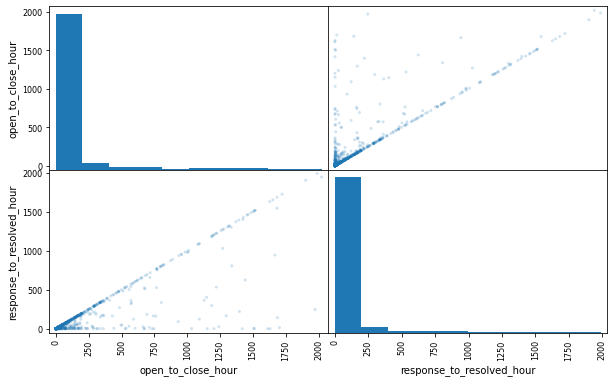

In [127]:
pd.plotting.scatter_matrix(df_all[numbericCols], alpha=0.2,figsize=(10,6))

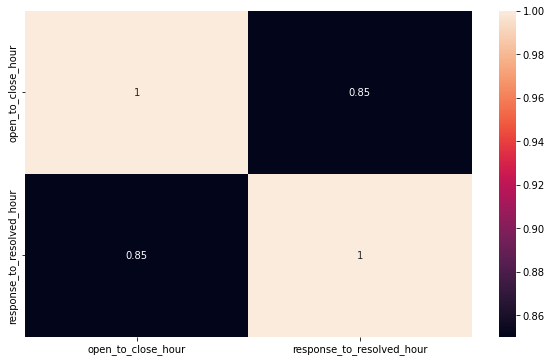

In [128]:
corr_df = df_all[numbericCols].corr ()  
corr_df = corr_df .round(2)

fig = plt.figure(figsize = (10, 6))
heatmap = sns. heatmap(corr_df, annot = True) 
plt. show ()

# Manage Categorical Cols

In [129]:
VBar=['brand','incident_type']
HBar=[ x for x in cateCols if x not in VBar]
HBar.insert(0,'severity_name')

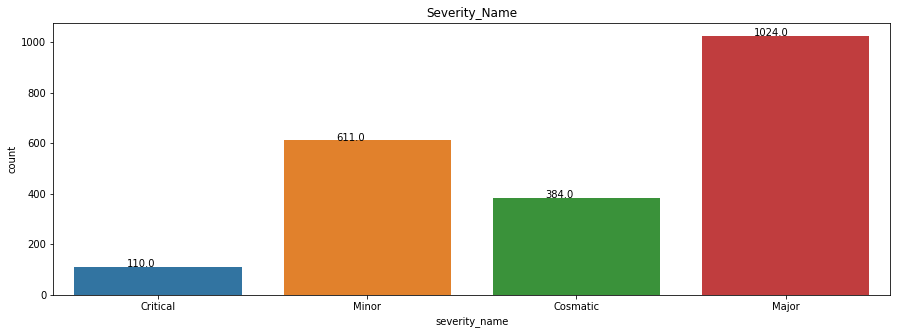

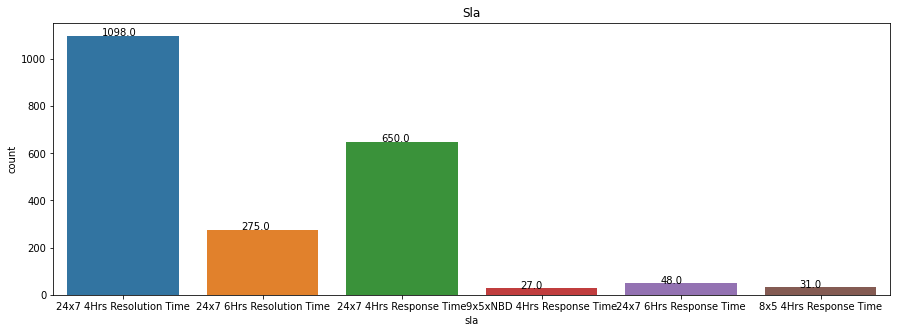

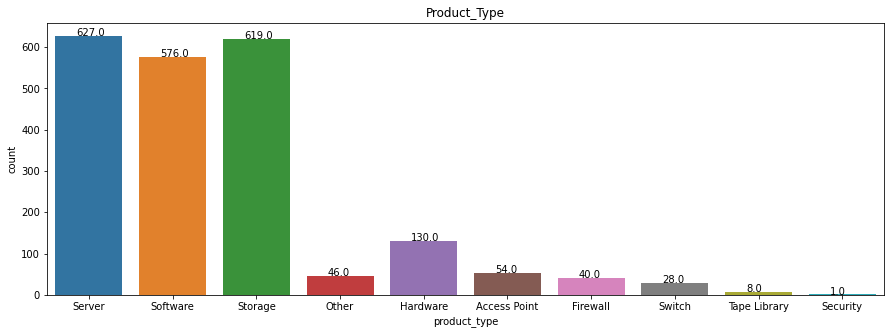

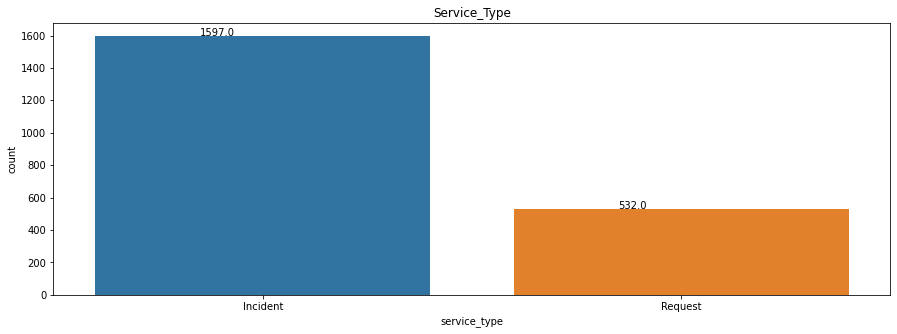

In [130]:
for col in HBar:
    fig , ax = plt.subplots(figsize=(15,5))
    ax =sns.countplot(x=col, data=df_all,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title(col.title())
    plt.show()

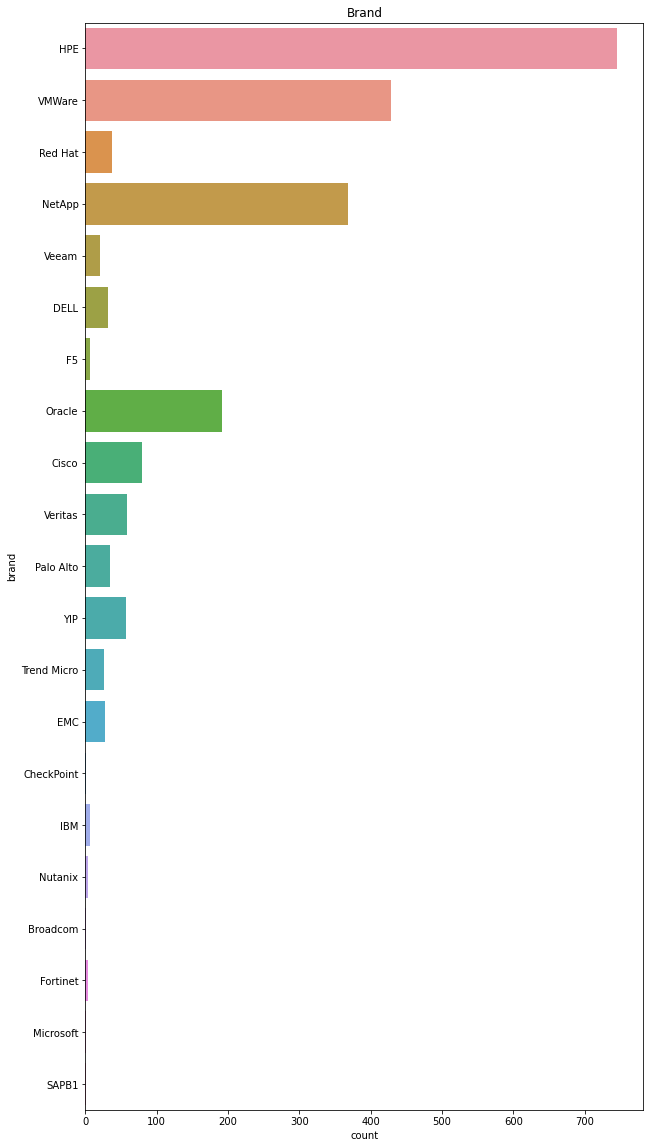

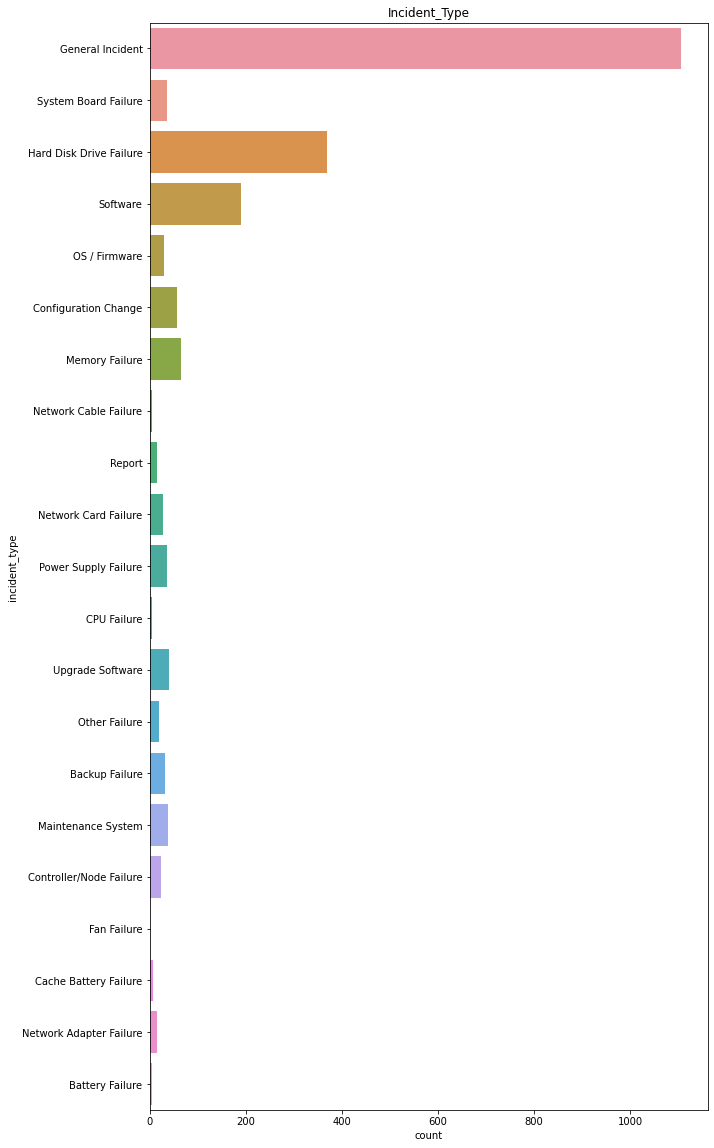

In [131]:
for col in VBar:
    fig , ax = plt.subplots(figsize=(10,20))
    ax =sns.countplot(y=col, data=df_all)
    plt.title(col.title())
    plt.show()

In [132]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2129 entries, 0 to 2276
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   severity_id                2129 non-null   int64  
 1   severity_name              2129 non-null   object 
 2   sla                        2129 non-null   object 
 3   product_type               2129 non-null   object 
 4   brand                      2129 non-null   object 
 5   service_type               2129 non-null   object 
 6   incident_type              2129 non-null   object 
 7   open_to_close_hour         2129 non-null   float64
 8   response_to_resolved_hour  2129 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 166.3+ KB


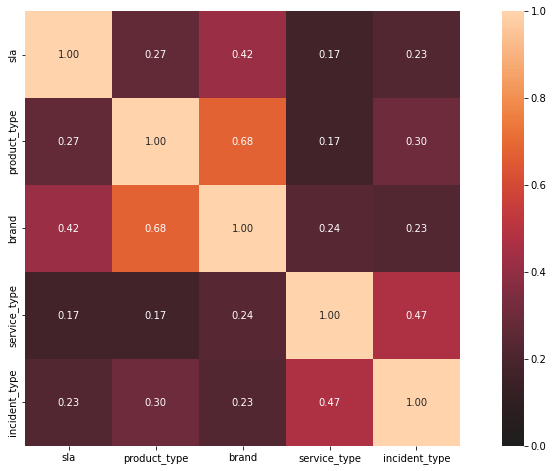

In [133]:
complete_correlation= associations(df_all[ [x for x in list(df_all.columns) if x not in ['severity_id','severity_name']+numbericCols]  ], figsize=(15,8))

In [134]:
if to_where=='local' and is_splited==False:
    print("Save to local and not split")
    df_all.to_csv("data/TrainEval_Incident.csv",index=False)
elif  to_where=='local' and is_splited==True:
    print("Save to local and split")
    df_train = df_all.sample(frac = 0.8, random_state=100)
    df_train.to_csv("data/Train_Incident.csv",index=False)
    df_test = df_all.drop(df_train.index)
    df_test.to_csv("data/Eval_Incident.csv",index=False)
else:
    print("No option")


Save to local and not split


In [135]:
df_train

,severity_id,severity_name,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour
32,4,Cosmatic,24x7 4Hrs Resolution Time,Access Point,Cisco,Request,Configuration Change,0.500000,0.500000
1340,2,Major,24x7 4Hrs Resolution Time,Hardware,Oracle,Incident,Hard Disk Drive Failure,28.000000,27.750000
1788,2,Major,24x7 4Hrs Resolution Time,Server,HPE,Incident,General Incident,13.300000,6.983333
465,4,Cosmatic,24x7 4Hrs Resolution Time,Server,HPE,Request,General Incident,3.366667,3.000000
1677,2,Major,24x7 4Hrs Response Time,Server,DELL,Incident,Hard Disk Drive Failure,8.000000,7.550000
...,...,...,...,...,...,...,...,...,...
59,3,Minor,24x7 6Hrs Resolution Time,Software,VMWare,Incident,General Incident,4.500000,3.833333
1831,2,Major,24x7 4Hrs Resolution Time,Storage,HPE,Incident,Hard Disk Drive Failure,113.850000,90.516667
722,2,Major,24x7 4Hrs Resolution Time,Server,HPE,Incident,Memory Failure,2.300000,1.933333
1707,1,Critical,9x5xNBD 4Hrs Response Time,Server,HPE,Incident,Memory Failure,6.300000,6.166667


In [136]:
# train_csv_file='Incident.csv'
# if to_where=='local':
#    df.to_csv(f"data/{train_csv_file}",index=False)  
# elif to_where=='gcs':
#    gcs_path="gs://smart-ml-pongthorn"
#    df.to_csv(f"{gcs_path}/{train_csv_file}",index=False) -

In [137]:
df_train.shape

(1703, 9)

In [140]:
df_test.shape

(426, 9)